# EDA for Baseline Performance
### Setup and import baseline policies data

In [1]:
# ==========================================
#  CONFIGURATION SWITCH
#  Options: "PROPOSED" (Your advanced sim) or "PAPER" (Replication)
# ==========================================
ENV_MODE = "PAPER" 
# ==========================================

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import importlib

# Add project root to path to import your custom policies
sys.path.append(os.path.abspath('..'))
from scripts.baseline_policies import (
    policy_always_d2d, policy_always_cellular, 
    policy_random, policy_sinr_threshold, policy_ground_truth
)

# Dynamically import the config from the selected simulator module
if ENV_MODE == "PAPER":
    from simulator_paper.config import PaperConfig as Config
    results_filename = "baseline_results_paper.csv"
    print(f"✓ MODE: PAPER REPLICATION (Using PaperConfig)")
else:
    from simulator.config import SimulationConfig as Config
    results_filename = "baseline_results_proposed.csv"
    print(f"✓ MODE: PROPOSED SIMULATION (Using SimulationConfig)")

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

✓ MODE: PAPER REPLICATION (Using PaperConfig)


### Load baseline policies data

In [3]:
# Load the summary results
summary_path = os.path.join('..', 'data', results_filename)

if os.path.exists(summary_path):
    df_results = pd.read_csv(summary_path)
    print("Loaded Baseline Results:")
    display(df_results)
else:
    print("Error: Could not find baseline_results_paper.csv or baseline_results_proposed.csv. Run 'run_baselines.py' first.")

Loaded Baseline Results:


,Policy,Avg Throughput (Mbps),Spectral Eff (bps/Hz),Switching Rate (per 100s),Avg D2D Residence (s)
0,Always D2D,0.71,0.07,0.00,300.00
1,Always Cellular,0.98,0.10,0.00,0.00
2,Random,0.77,0.08,46.33,2.16
3,SINR Threshold (0dB),0.98,0.10,0.00,0.00
4,Ground Truth (Max Tput),1.53,0.15,0.33,222.00


### Visualize baseline performance metrics

C:\Users\Zul Arif Nael\AppData\Local\Temp\ipykernel_33488\2227687892.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Policy', y='Avg Throughput (Mbps)', data=df_results, ax=axes[0], palette='viridis')
C:\Users\Zul Arif Nael\AppData\Local\Temp\ipykernel_33488\2227687892.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Policy', y='Switching Rate (per 100s)', data=df_results, ax=axes[1], palette='magma')


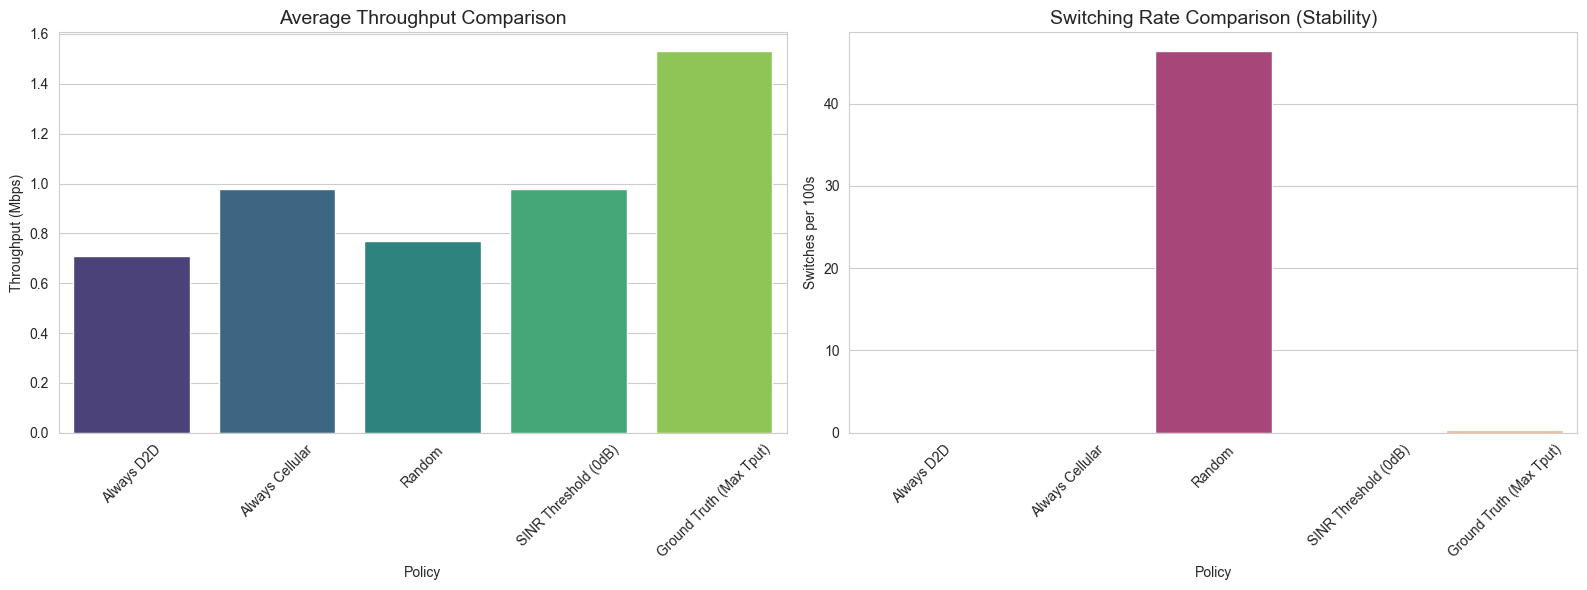

In [4]:
if os.path.exists(summary_path):
    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Average Throughput (The "Performance" Metric)
    sns.barplot(x='Policy', y='Avg Throughput (Mbps)', data=df_results, ax=axes[0], palette='viridis')
    axes[0].set_title('Average Throughput Comparison', fontsize=14)
    axes[0].set_ylabel('Throughput (Mbps)')
    axes[0].tick_params(axis='x', rotation=45) # Rotate labels to fit
    
    # Plot 2: Switching Rate (The "Cost" Metric)
    sns.barplot(x='Policy', y='Switching Rate (per 100s)', data=df_results, ax=axes[1], palette='magma')
    axes[1].set_title('Switching Rate Comparison (Stability)', fontsize=14)
    axes[1].set_ylabel('Switches per 100s')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

### Timeline analyis for Episode 0 only

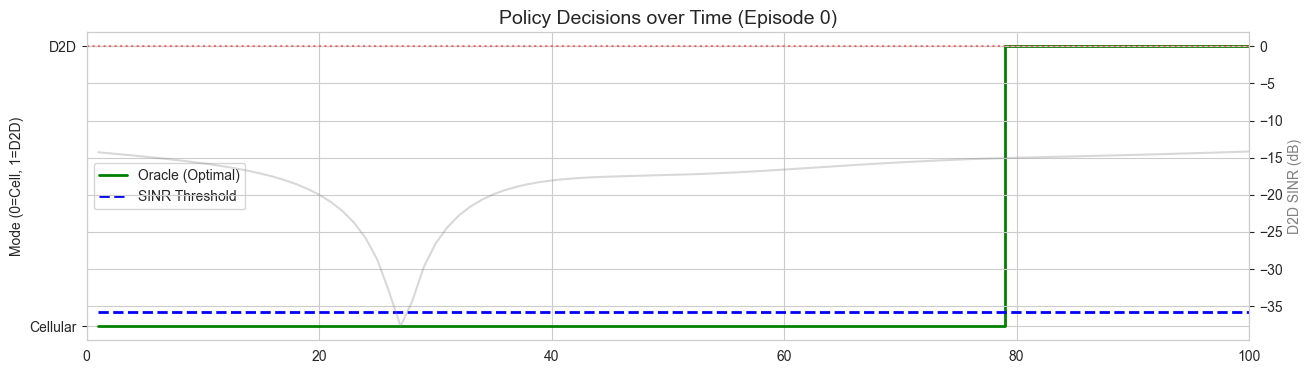

In [5]:
# 1. Load the raw simulation data
raw_path = os.path.join('..', Config.OUTPUT_FILE)
df_raw = pd.read_csv(raw_path)

# 2. Select ONLY Episode 0 (The first run)
episode_0 = df_raw[df_raw['episode_id'] == 0].copy().reset_index(drop=True)

# 3. Re-run the policies on this single episode
ep0_oracle = policy_ground_truth(episode_0)
ep0_threshold = policy_sinr_threshold(episode_0, threshold_db=0)
ep0_random = policy_random(episode_0)

# 4. Convert "D2D"/"Cellular" text to numbers (1/0) for plotting
# D2D = 1, Cellular = 0
trace_oracle = ep0_oracle.apply(lambda x: 1 if x == 'D2D' else 0)
trace_threshold = ep0_threshold.apply(lambda x: 1 if x == 'D2D' else 0)
trace_random = ep0_random.apply(lambda x: 1 if x == 'D2D' else 0)

# 5. Plot the Timeline
plt.figure(figsize=(15, 4))

# Plot Oracle (Ground Truth)
plt.step(episode_0['timestamp'], trace_oracle, where='post', label='Oracle (Optimal)', linewidth=2, color='green')

# Plot Threshold (Heuristic) -> Shifted slightly up so we can see it
plt.step(episode_0['timestamp'], trace_threshold + 0.05, where='post', label='SINR Threshold', linewidth=2, linestyle='--', color='blue')

# Plot SINR on a secondary axis to explain WHY it switched
plt.ylabel('Mode (0=Cell, 1=D2D)')
plt.yticks([0, 1], ['Cellular', 'D2D'])
plt.title('Policy Decisions over Time (Episode 0)', fontsize=14)
plt.legend(loc='center left')   

# Add SINR context
ax2 = plt.gca().twinx()
ax2.plot(episode_0['timestamp'], episode_0['sinr_d2d_db'], color='gray', alpha=0.3, label='D2D SINR (dB)')
ax2.axhline(0, color='red', linestyle=':', alpha=0.5, label='0dB Threshold')
ax2.set_ylabel('D2D SINR (dB)', color='gray')

plt.xlim(0, 100)
plt.show()

### Comment 1
The high amount of switching for the ground truth policy shows why it has a high switching rate (~30%). It can also be observed that the for SINR threshold policy, it only switched mode when the D2D SINR is above 0 dB. This indicates wasted potential where there are many instances where D2D mode gives a higher throughput, but the SINR threshold policy missed them many times. This problem will be solved using the deep learning models. 